### Preamble

In [2]:
import pandas as pd
from rdkit import Chem

In [4]:
import os 
import sys

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Add the parent directory to the system path
sys.path.insert(0, parent_dir)

import os_navigation as os_nav

In [5]:
from dft.molecule import Molecule, MoleculeType, MoleculeInfo, MoleculeSubtype
from dft.job_utils import JobInfo

### Loading Data

In [21]:
out_file_dir = os.path.join(os_nav.find_project_root(), 'out')
molecule_cache = os.path.join(os_nav.find_project_root(), 'data', 'mols', 'wittig_molecules.csv')
reaction_json = os.path.join(os_nav.find_project_root(), 'data', 'all_dfs.json')


In [22]:
# Load the necessary data files
molecule_df = pd.read_csv(molecule_cache)
reaction_df = pd.read_json(reaction_json)

### Data Processing

In [23]:
# Define a function to extract thermodynamic properties from .out files
def extract_thermo_properties(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    thermo_properties = {}
    for i, line in enumerate(lines):
        if 'Total internal energy, Utot' in line:
            total_energy = float(line.split()[-2])
            thermo_properties['Utot'] = total_energy
        if 'Total enthalpy, Htot' in line:
            total_enthalpy = float(line.split()[-2])
            thermo_properties['Htot'] = total_enthalpy
        if 'Total Gibbs free energy, Gtot' in line:
            total_gibbs = float(line.split()[-2])
            thermo_properties['Gtot'] = total_gibbs
    
    return thermo_properties

# Define a function to canonicalize SMILES strings
def canonicalize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.MolToSmiles(mol, canonical=True)

# Canonicalize SMILES strings in reaction_df
reaction_df['ald_smiles_canonical'] = reaction_df['ald_smiles'].apply(canonicalize_smiles)
reaction_df['ylide_smiles_canonical'] = reaction_df['ylide_smiles'].apply(canonicalize_smiles)
reaction_df['cis_pdt_canonical'] = reaction_df['cis_pdt'].apply(canonicalize_smiles)
reaction_df['trans_pdt_canonical'] = reaction_df['trans_pdt'].apply(canonicalize_smiles)

In [28]:
# Function to calculate delta G
def calculate_delta_g(product_g, ald_g, ylide_g):
    return product_g - ald_g - ylide_g

# Find the .out file for a given molecule ID and job code
def find_out_file(mol_id, job_code):
    directory = os.path.join(out_file_dir, f'J1_{mol_id}_{job_code}')
    if os.path.exists(directory):
        for file in os.listdir(directory):
            if file.endswith('.out'):
                return os.path.join(directory, file)
    return None

# Function to get the molecule ID for a given canonical SMILES string from molecule_df
def get_mol_id(smiles, molecule_df):
    try:
        return molecule_df[molecule_df['smiles'] == smiles]['index'].values[0]
    except IndexError:
        return None

# Initialize list to hold successful reaction entries
successful_reactions = []

In [29]:


# Loop through each reaction in reaction_df
for _, row in reaction_df.iterrows():
    try:
        ald_id = get_mol_id(row['ald_smiles_canonical'], molecule_df)
        ylide_id = get_mol_id(row['ylide_smiles_canonical'], molecule_df)
        cis_id = get_mol_id(row['cis_pdt_canonical'], molecule_df)
        trans_id = get_mol_id(row['trans_pdt_canonical'], molecule_df)
        
        if ald_id is None or ylide_id is None:
            continue
        
        delta_g_cis_list = []
        delta_g_trans_list = []
        
        for job_code in ['2111', '3111']:
            ald_out_file = find_out_file(ald_id, job_code)
            ylide_out_file = find_out_file(ylide_id, job_code)
            cis_out_file = find_out_file(cis_id, job_code)
            trans_out_file = find_out_file(trans_id, job_code)
            
            if ald_out_file and ylide_out_file and cis_out_file and trans_out_file:
                ald_thermo = extract_thermo_properties(ald_out_file)
                ylide_thermo = extract_thermo_properties(ylide_out_file)
                cis_thermo = extract_thermo_properties(cis_out_file)
                trans_thermo = extract_thermo_properties(trans_out_file)
                
                if 'Gtot' in ald_thermo and 'Gtot' in ylide_thermo and 'Gtot' in cis_thermo and 'Gtot' in trans_thermo:
                    delta_g_cis = calculate_delta_g(cis_thermo['Gtot'], ald_thermo['Gtot'], ylide_thermo['Gtot'])
                    delta_g_trans = calculate_delta_g(trans_thermo['Gtot'], ald_thermo['Gtot'], ylide_thermo['Gtot'])
                    
                    delta_g_cis_list.append((job_code, delta_g_cis))
                    delta_g_trans_list.append((job_code, delta_g_trans))
        
        if delta_g_cis_list and delta_g_trans_list:
            row['delta_g_cis'] = delta_g_cis_list
            row['delta_g_trans'] = delta_g_trans_list
            successful_reactions.append(row)
    
    except Exception as e:
        print(f"Error processing reaction {row['entry']}: {e}")

# Convert successful reactions to DataFrame
successful_reactions_df = pd.DataFrame(successful_reactions)

# Display the results
successful_reactions_df.head()

,entry,rxn_smiles,X,temp,z,ald_smiles,ylide_smiles,base_smiles,solvent_smiles,pdt_smiles,...,trans_pdt,cis_mapped_rxn,trans_mapped_rxn,table,ald_smiles_canonical,ylide_smiles_canonical,cis_pdt_canonical,trans_pdt_canonical,delta_g_cis,delta_g_trans
0,1,CCC=O.CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1.[Na]N....,Br,0,97,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,[Na]N,CCOCC.C1=CC=CC=C1,CC[C@H]1[C@@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccc...,...,CC[C@H]1[C@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccccc1,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,11,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,CC[C@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,CC[C@@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,"[(2111, -0.015163999999913358), (3111, -0.0117...","[(2111, -0.02029299999981049), (3111, -0.01443..."
1,2,CCC=O.CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1.[K].O=...,Br,25,96,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,[K],O=P(N(C)C)(N(C)C)N(C)C,CC[C@H]1[C@@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccc...,...,CC[C@H]1[C@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccccc1,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,11,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,CC[C@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,CC[C@@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,"[(2111, -0.015163999999913358), (3111, -0.0117...","[(2111, -0.02029299999981049), (3111, -0.01443..."
2,3,CCC=O.CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1.[Li]CC...,Cl,25,94,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,[Li]CCCC,O=CN(C)C,CC[C@H]1[C@@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccc...,...,CC[C@H]1[C@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccccc1,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,11,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,CC[C@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,CC[C@@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,"[(2111, -0.015163999999913358), (3111, -0.0117...","[(2111, -0.02029299999981049), (3111, -0.01443..."
3,4,CCC=O.CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1.[Li]CC...,I,25,95,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,[Li]CCCC,O=CN(C)C,CC[C@H]1[C@@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccc...,...,CC[C@H]1[C@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccccc1,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,11,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,CC[C@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,CC[C@@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,"[(2111, -0.015163999999913358), (3111, -0.0117...","[(2111, -0.02029299999981049), (3111, -0.01443..."
4,5,CCC=O.CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1.[Li]CC...,I,25,92,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,[Li]CCCC,C1=CC=CC=C1,CC[C@H]1[C@@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccc...,...,CC[C@H]1[C@H](CC)OP1(c1ccccc1)(c1ccccc1)c1ccccc1,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,[CH3:1][CH2:2][CH:3]=[O:4].[CH3:5][CH2:6][CH:7...,11,CCC=O,CCC=P(c1ccccc1)(c1ccccc1)c1ccccc1,CC[C@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,CC[C@@H]1OP(c2ccccc2)(c2ccccc2)(c2ccccc2)[C@H]1CC,"[(2111, -0.015163999999913358), (3111, -0.0117...","[(2111, -0.02029299999981049), (3111, -0.01443..."


### Comparison Plot

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

hartree_to_kcalmol = 627.509

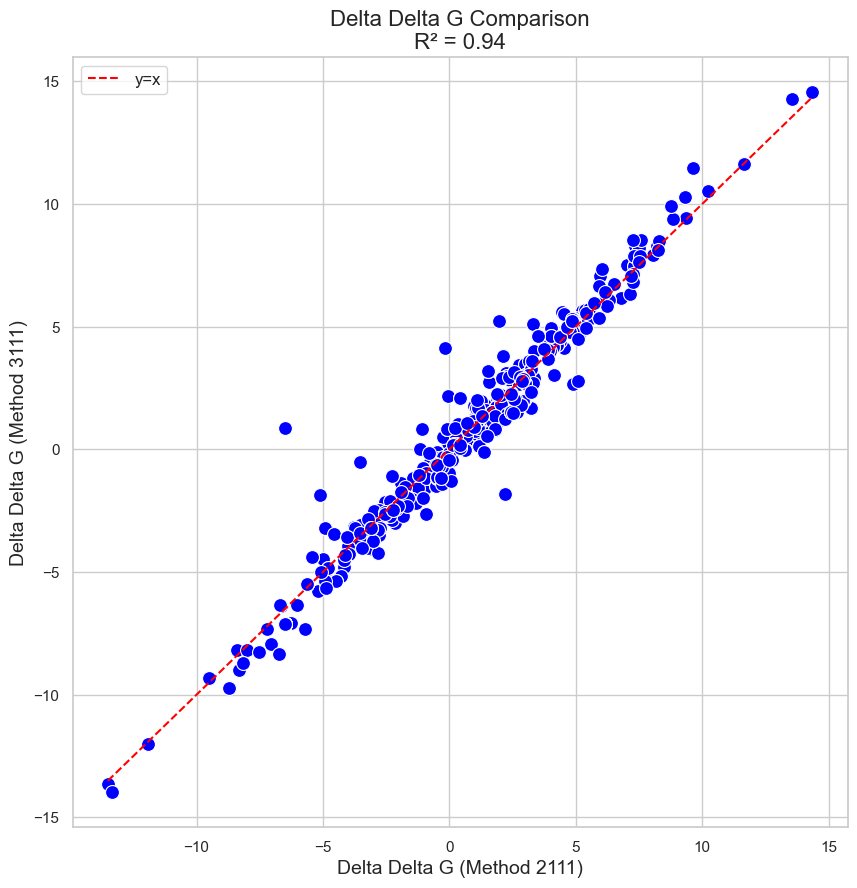

In [62]:

# Function to calculate delta delta G values
def calculate_delta_delta_g(delta_g_cis_list, delta_g_trans_list):
    delta_g_cis_dict = dict(delta_g_cis_list)
    delta_g_trans_dict = dict(delta_g_trans_list)
    if '2111' in delta_g_cis_dict and '3111' in delta_g_cis_dict and '2111' in delta_g_trans_dict and '3111' in delta_g_trans_dict:
        delta_delta_g_2111 = (delta_g_cis_dict['2111'] - delta_g_trans_dict['2111']) * hartree_to_kcalmol
        delta_delta_g_3111 = (delta_g_cis_dict['3111'] - delta_g_trans_dict['3111']) * hartree_to_kcalmol
        return delta_delta_g_2111, delta_delta_g_3111
    return None, None

# Calculate delta delta G values
successful_reactions_df['delta_delta_g_2111'] = np.nan
successful_reactions_df['delta_delta_g_3111'] = np.nan

for idx, row in successful_reactions_df.iterrows():
    delta_delta_g_2111, delta_delta_g_3111 = calculate_delta_delta_g(row['delta_g_cis'], row['delta_g_trans'])
    successful_reactions_df.at[idx, 'delta_delta_g_2111'] = delta_delta_g_2111
    successful_reactions_df.at[idx, 'delta_delta_g_3111'] = delta_delta_g_3111

# Drop rows with NaN values in delta delta G columns
plot_df = successful_reactions_df.dropna(subset=['delta_delta_g_2111', 'delta_delta_g_3111'])

# Set seaborn style
sns.set(style="whitegrid")

# Scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x='delta_delta_g_2111', y='delta_delta_g_3111', data=plot_df, color='blue', s=100)
plt.plot([plot_df['delta_delta_g_2111'].min(), plot_df['delta_delta_g_2111'].max()],
         [plot_df['delta_delta_g_2111'].min(), plot_df['delta_delta_g_2111'].max()],
         color='red', linestyle='--', label='y=x')

# Compute R² value
r2 = r2_score(plot_df['delta_delta_g_2111'], plot_df['delta_delta_g_3111'])
plt.title(f'Delta Delta G Comparison\nR² = {r2:.2f}', fontsize=16)
plt.xlabel('Delta Delta G (Method 2111)', fontsize=14)
plt.ylabel('Delta Delta G (Method 3111)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


/var/folders/ym/87tvff3s4613jztcqjjdb2z40000gn/T/ipykernel_15826/2758900899.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['residuals'] = plot_df['delta_delta_g_3111'] - plot_df['delta_delta_g_2111']


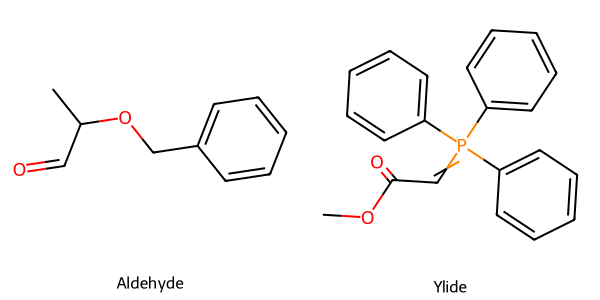

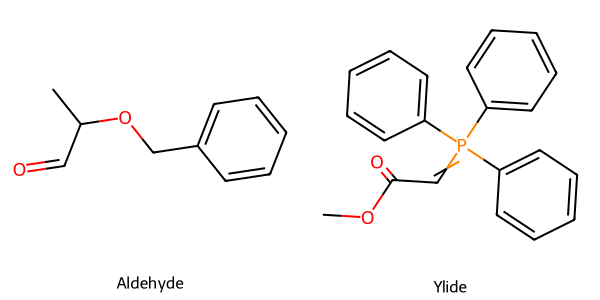

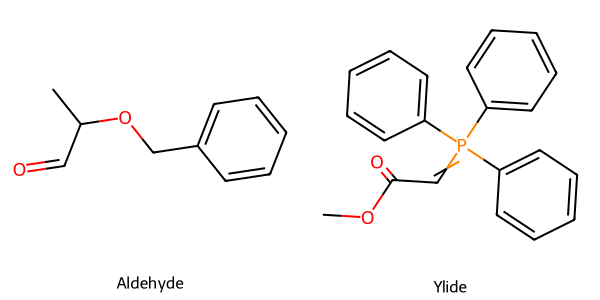

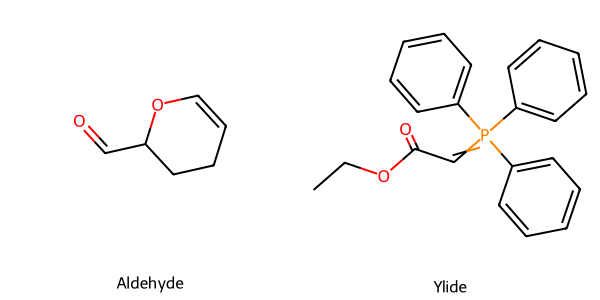

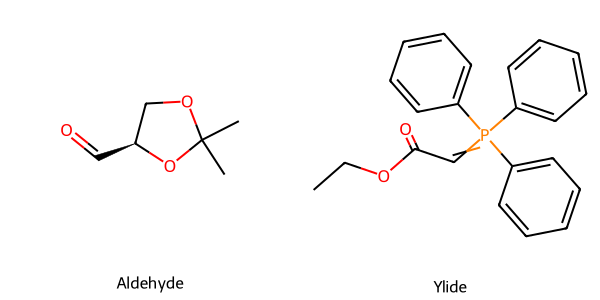

In [51]:

# Function to calculate delta delta G values
def calculate_delta_delta_g(delta_g_cis_list, delta_g_trans_list):
    delta_g_cis_dict = dict(delta_g_cis_list)
    delta_g_trans_dict = dict(delta_g_trans_list)
    if '2111' in delta_g_cis_dict and '3111' in delta_g_cis_dict and '2111' in delta_g_trans_dict and '3111' in delta_g_trans_dict:
        delta_delta_g_2111 = delta_g_cis_dict['2111'] - delta_g_trans_dict['2111']
        delta_delta_g_3111 = delta_g_cis_dict['3111'] - delta_g_trans_dict['3111']
        return delta_delta_g_2111, delta_delta_g_3111
    return None, None

# Calculate delta delta G values
successful_reactions_df['delta_delta_g_2111'] = np.nan
successful_reactions_df['delta_delta_g_3111'] = np.nan

for idx, row in successful_reactions_df.iterrows():
    delta_delta_g_2111, delta_delta_g_3111 = calculate_delta_delta_g(row['delta_g_cis'], row['delta_g_trans'])
    successful_reactions_df.at[idx, 'delta_delta_g_2111'] = delta_delta_g_2111
    successful_reactions_df.at[idx, 'delta_delta_g_3111'] = delta_delta_g_3111

# Drop rows with NaN values in delta delta G columns
plot_df = successful_reactions_df.dropna(subset=['delta_delta_g_2111', 'delta_delta_g_3111'])

# Calculate residuals
plot_df['residuals'] = plot_df['delta_delta_g_3111'] - plot_df['delta_delta_g_2111']

# Identify the largest outliers
num_outliers = 5
largest_outliers = plot_df.nlargest(num_outliers, 'residuals')

# Draw the reactants for the largest outliers
for idx, row in largest_outliers.iterrows():
    ald_mol = Chem.MolFromSmiles(row['ald_smiles'])
    ylide_mol = Chem.MolFromSmiles(row['ylide_smiles'])
    
    img = Draw.MolsToGridImage([ald_mol, ylide_mol], molsPerRow=2, subImgSize=(300, 300),
                               legends=['Aldehyde', 'Ylide'])
    display(img)


/var/folders/ym/87tvff3s4613jztcqjjdb2z40000gn/T/ipykernel_15826/4270851318.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['residuals'] = plot_df['delta_delta_g_3111'] - plot_df['delta_delta_g_2111']


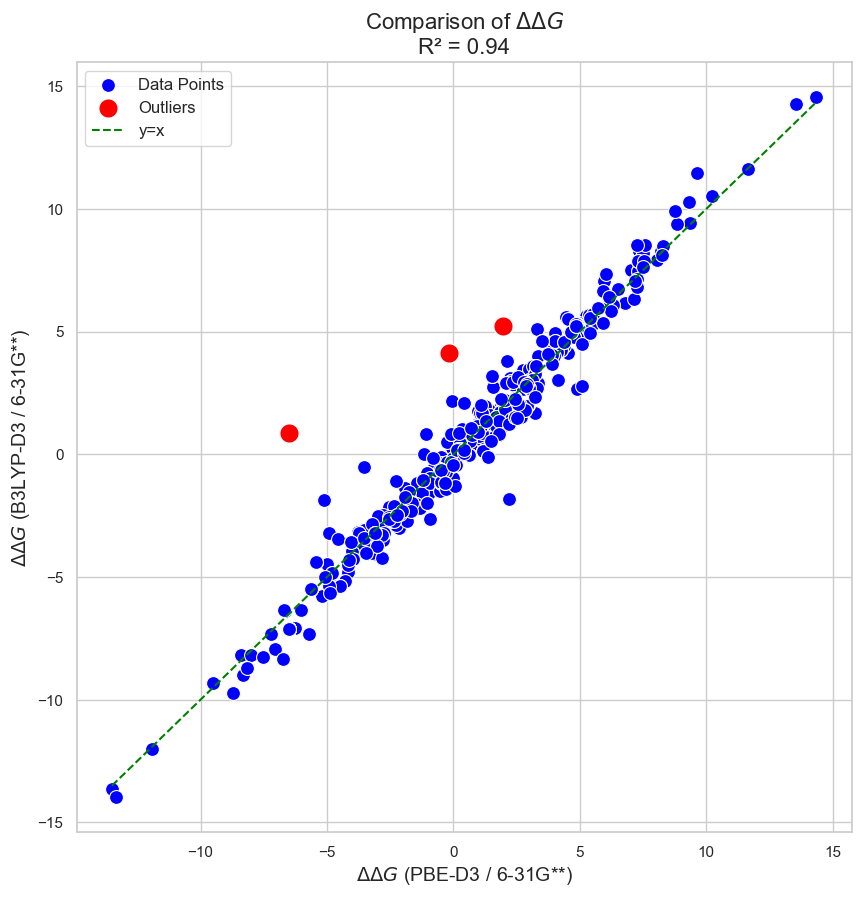

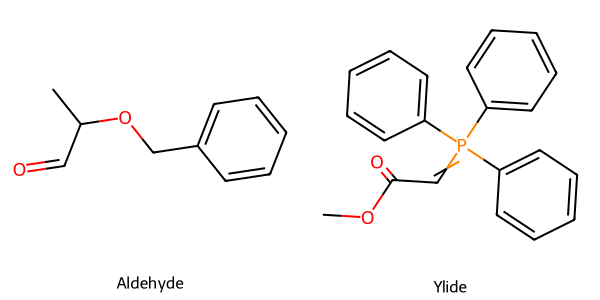

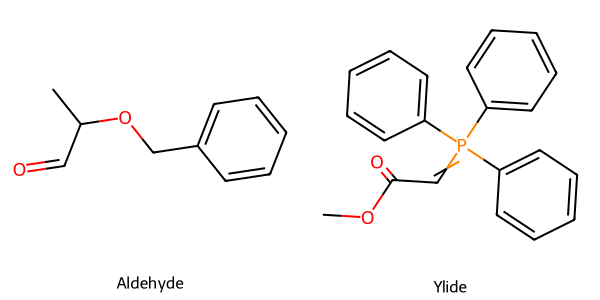

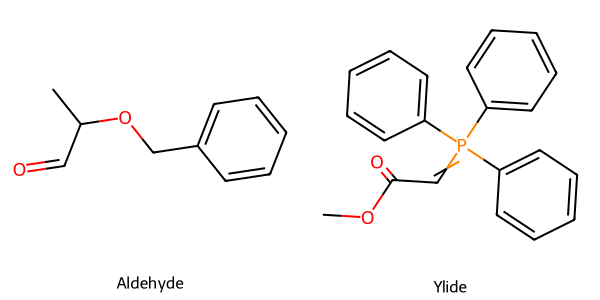

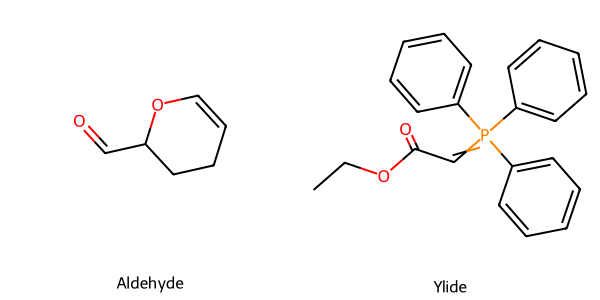

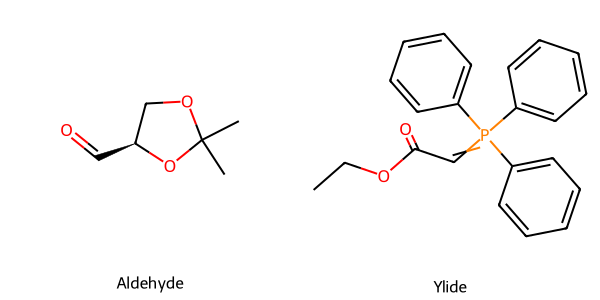

In [64]:


# Calculate delta delta G values
successful_reactions_df['delta_delta_g_2111'] = np.nan
successful_reactions_df['delta_delta_g_3111'] = np.nan

for idx, row in successful_reactions_df.iterrows():
    delta_delta_g_2111, delta_delta_g_3111 = calculate_delta_delta_g(row['delta_g_cis'], row['delta_g_trans'])
    successful_reactions_df.at[idx, 'delta_delta_g_2111'] = delta_delta_g_2111
    successful_reactions_df.at[idx, 'delta_delta_g_3111'] = delta_delta_g_3111

# Drop rows with NaN values in delta delta G columns
plot_df = successful_reactions_df.dropna(subset=['delta_delta_g_2111', 'delta_delta_g_3111'])

# Calculate residuals
plot_df['residuals'] = plot_df['delta_delta_g_3111'] - plot_df['delta_delta_g_2111']

# Identify the largest outliers
num_outliers = 5
largest_outliers = plot_df.nlargest(num_outliers, 'residuals')

# Set seaborn style
sns.set(style="whitegrid")

# Scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x='delta_delta_g_2111', y='delta_delta_g_3111', data=plot_df, color='blue', s=100, label='Data Points')

# Highlight the largest outliers
sns.scatterplot(x='delta_delta_g_2111', y='delta_delta_g_3111', data=largest_outliers, color='red', s=200, label='Outliers')

# Plot y=x line
plt.plot([plot_df['delta_delta_g_2111'].min(), plot_df['delta_delta_g_2111'].max()],
         [plot_df['delta_delta_g_2111'].min(), plot_df['delta_delta_g_2111'].max()],
         color='green', linestyle='--', label='y=x')

# Compute R² value
r2 = r2_score(plot_df['delta_delta_g_2111'], plot_df['delta_delta_g_3111'])
plt.title(f'Comparison of $\Delta \Delta G$\nR² = {r2:.2f}', fontsize=16)
plt.xlabel('$\Delta \Delta G$ (PBE-D3 / 6-31G**)', fontsize=14)
plt.ylabel('$\Delta \Delta G$ (B3LYP-D3 / 6-31G**)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Draw the reactants for the largest outliers
for idx, row in largest_outliers.iterrows():
    ald_mol = Chem.MolFromSmiles(row['ald_smiles'])
    ylide_mol = Chem.MolFromSmiles(row['ylide_smiles'])
    
    img = Draw.MolsToGridImage([ald_mol, ylide_mol], molsPerRow=2, subImgSize=(300, 300),
                               legends=['Aldehyde', 'Ylide'])
    display(img)


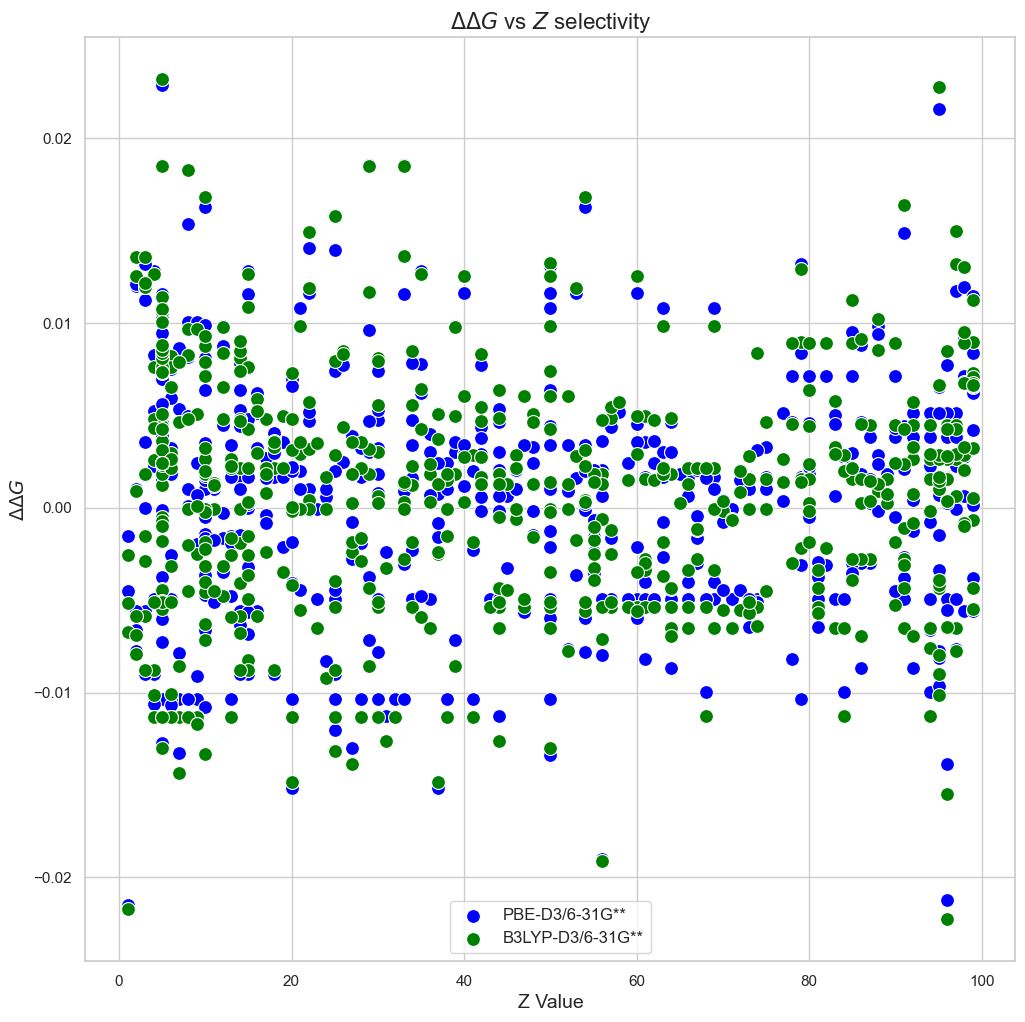

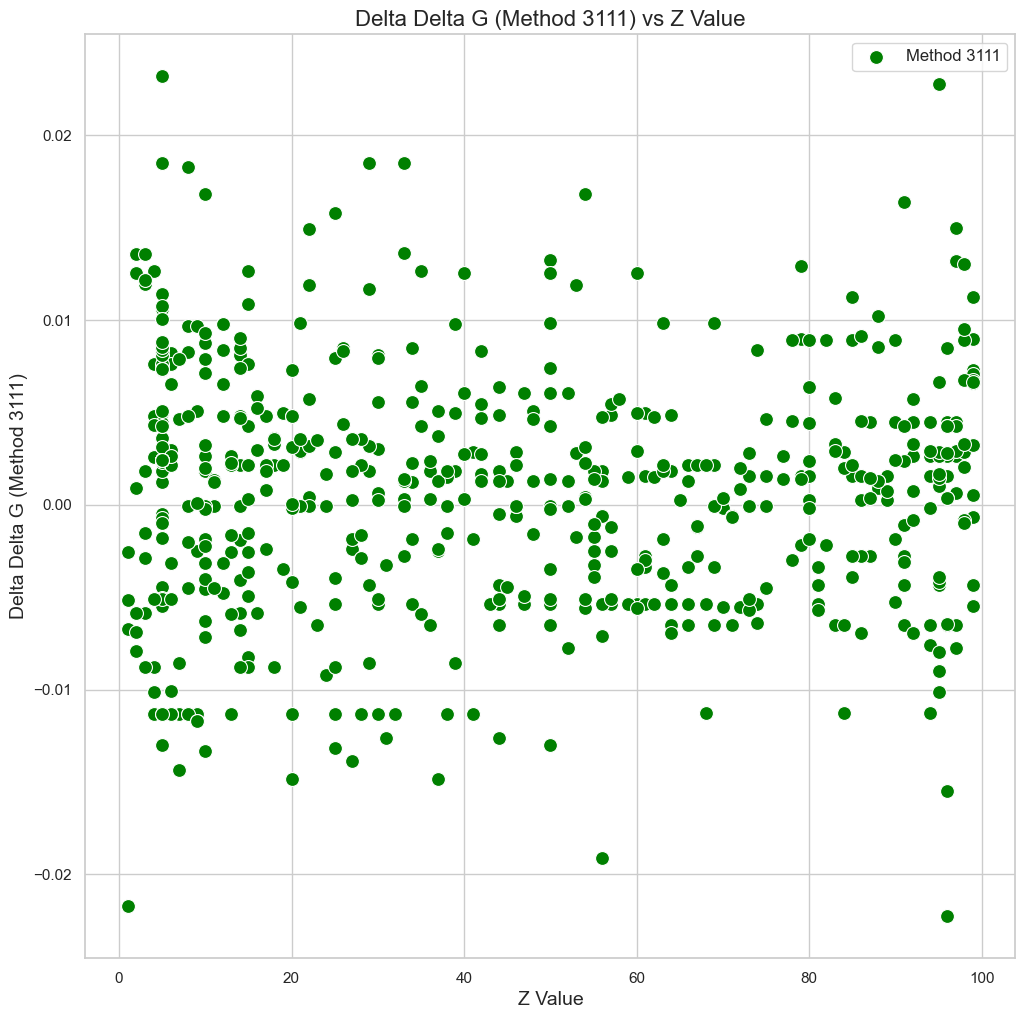

In [78]:
# Function to calculate delta delta G values
def calculate_delta_delta_g(delta_g_cis_list, delta_g_trans_list):
    delta_g_cis_dict = dict(delta_g_cis_list)
    delta_g_trans_dict = dict(delta_g_trans_list)
    if '2111' in delta_g_cis_dict and '3111' in delta_g_cis_dict and '2111' in delta_g_trans_dict and '3111' in delta_g_trans_dict:
        delta_delta_g_2111 = delta_g_cis_dict['2111'] - delta_g_trans_dict['2111']
        delta_delta_g_3111 = delta_g_cis_dict['3111'] - delta_g_trans_dict['3111']
        return delta_delta_g_2111, delta_delta_g_3111
    return None, None

# Calculate delta delta G values
successful_reactions_df['delta_delta_g_2111'] = np.nan
successful_reactions_df['delta_delta_g_3111'] = np.nan

for idx, row in successful_reactions_df.iterrows():
    delta_delta_g_2111, delta_delta_g_3111 = calculate_delta_delta_g(row['delta_g_cis'], row['delta_g_trans'])
    successful_reactions_df.at[idx, 'delta_delta_g_2111'] = delta_delta_g_2111
    successful_reactions_df.at[idx, 'delta_delta_g_3111'] = delta_delta_g_3111

# Drop rows with NaN values in delta delta G columns
plot_df = successful_reactions_df.dropna(subset=['delta_delta_g_2111', 'delta_delta_g_3111'])

# Set seaborn style
# sns.set_theme()
sns.set(style="whitegrid")

# Plot delta delta G vs 'z' for method 2111
plt.figure(figsize=(12, 12))
sns.scatterplot(x='z', y='delta_delta_g_2111', data=plot_df, color='blue', s=100, label='PBE-D3/6-31G**')
sns.scatterplot(x='z', y='delta_delta_g_3111', data=plot_df, color='green', s=100, label='B3LYP-D3/6-31G**')
plt.title('$\Delta \Delta G$ vs $Z$ selectivity', fontsize=16)
plt.xlabel('Z Value', fontsize=14)
plt.ylabel('$\Delta \Delta G$', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot delta delta G vs 'z' for method 3111
plt.figure(figsize=(12, 12))
sns.scatterplot(x='z', y='delta_delta_g_3111', data=plot_df, color='green', s=100, label='Method 3111')
plt.title('Delta Delta G (Method 3111) vs Z Value', fontsize=16)
plt.xlabel('Z Value', fontsize=14)
plt.ylabel('Delta Delta G (Method 3111)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


/var/folders/ym/87tvff3s4613jztcqjjdb2z40000gn/T/ipykernel_15826/4270851318.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['residuals'] = plot_df['delta_delta_g_3111'] - plot_df['delta_delta_g_2111']


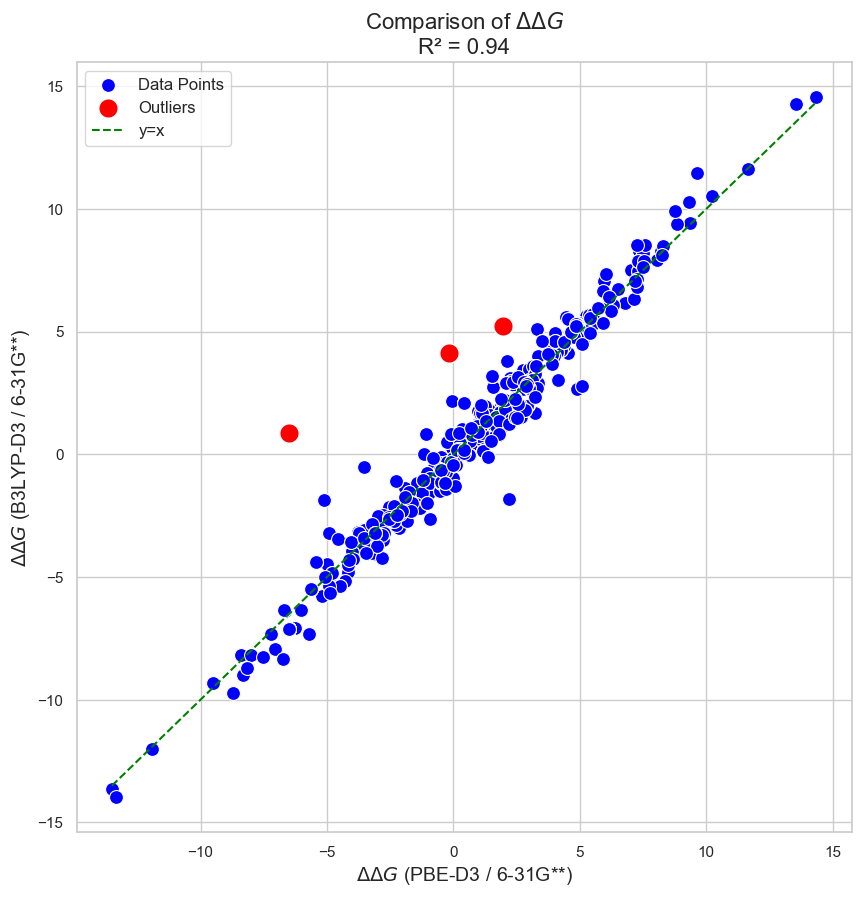

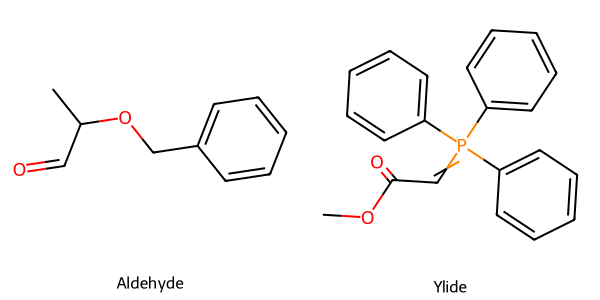

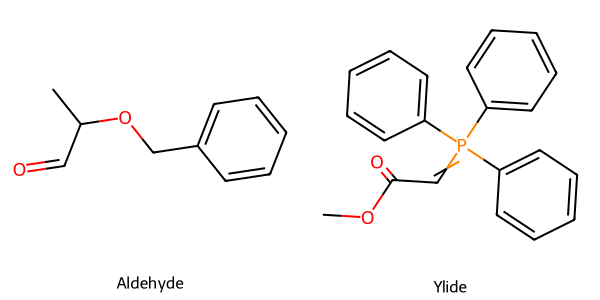

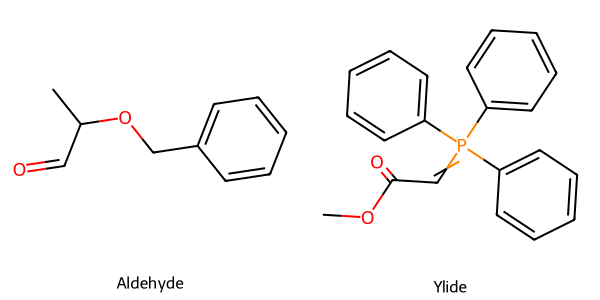

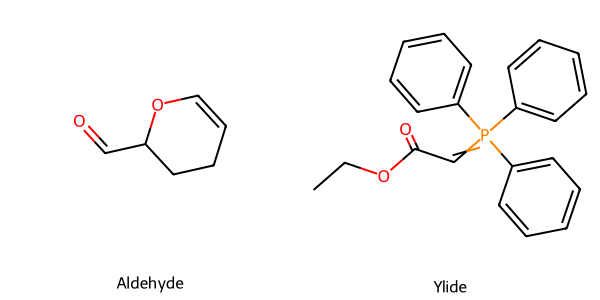

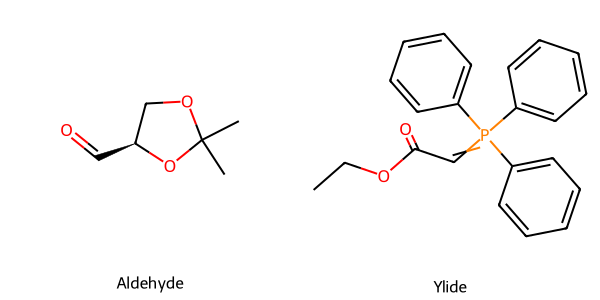

In [65]:


# Calculate delta delta G values
successful_reactions_df['delta_delta_g_2111'] = np.nan
successful_reactions_df['delta_delta_g_3111'] = np.nan

for idx, row in successful_reactions_df.iterrows():
    delta_delta_g_2111, delta_delta_g_3111 = calculate_delta_delta_g(row['delta_g_cis'], row['delta_g_trans'])
    successful_reactions_df.at[idx, 'delta_delta_g_2111'] = delta_delta_g_2111
    successful_reactions_df.at[idx, 'delta_delta_g_3111'] = delta_delta_g_3111

# Drop rows with NaN values in delta delta G columns
plot_df = successful_reactions_df.dropna(subset=['delta_delta_g_2111', 'delta_delta_g_3111'])

# Calculate residuals
plot_df['residuals'] = plot_df['delta_delta_g_3111'] - plot_df['delta_delta_g_2111']

# Identify the largest outliers
num_outliers = 5
largest_outliers = plot_df.nlargest(num_outliers, 'residuals')

# Set seaborn style
sns.set(style="whitegrid")

# Scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(x='delta_delta_g_2111', y='delta_delta_g_3111', data=plot_df, color='blue', s=100, label='Data Points')

# Highlight the largest outliers
sns.scatterplot(x='delta_delta_g_2111', y='delta_delta_g_3111', data=largest_outliers, color='red', s=200, label='Outliers')

# Plot y=x line
plt.plot([plot_df['delta_delta_g_2111'].min(), plot_df['delta_delta_g_2111'].max()],
         [plot_df['delta_delta_g_2111'].min(), plot_df['delta_delta_g_2111'].max()],
         color='green', linestyle='--', label='y=x')

# Compute R² value
r2 = r2_score(plot_df['delta_delta_g_2111'], plot_df['delta_delta_g_3111'])
plt.title(f'Comparison of $\Delta \Delta G$\nR² = {r2:.2f}', fontsize=16)
plt.xlabel('$\Delta \Delta G$ (PBE-D3 / 6-31G**)', fontsize=14)
plt.ylabel('$\Delta \Delta G$ (B3LYP-D3 / 6-31G**)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Draw the reactants for the largest outliers
for idx, row in largest_outliers.iterrows():
    ald_mol = Chem.MolFromSmiles(row['ald_smiles'])
    ylide_mol = Chem.MolFromSmiles(row['ylide_smiles'])
    
    img = Draw.MolsToGridImage([ald_mol, ylide_mol], molsPerRow=2, subImgSize=(300, 300),
                               legends=['Aldehyde', 'Ylide'])
    display(img)
